### Dimensionality Reduction Review
#### Feature selection
##### 07Dec18
Using proportional downsampling techniques, get subsets of discrete and continous data to feature-select prior to running DR algorithms for comparison on relatively low-dimensional raw data.

In [1]:
from fcc_utils import *
from fcc_DRs import *

Using TensorFlow backend.


In [98]:
# reload functions when editing file
import sys
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [2]:
retina_1 = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz', cells_axis=1) # cells are columns in this raw datafile

In [3]:
retina_1.data.shape # see how many (cells, features) we are working with

(6600, 20478)

---
#### 0. perform 100-component PCA on arcsinh-transformed raw data

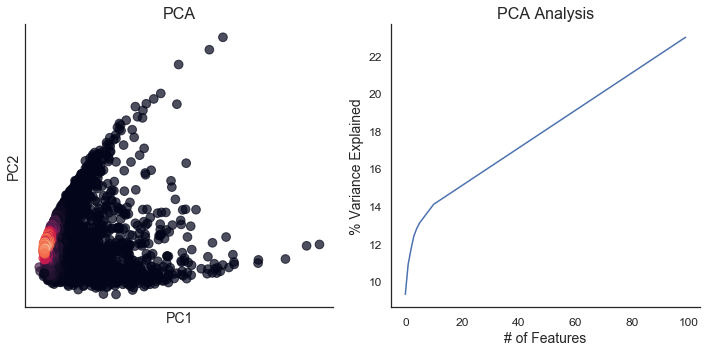

CPU times: user 29.9 s, sys: 6.86 s, total: 36.7 s
Wall time: 29.4 s


In [4]:
%%time
retina_1_PCA = fcc_PCA(retina_1.arcsinh_norm(), n_components=100)
retina_1_PCA.plot()

---
#### 1. perform t-SNE (perplexity 30) on PCA results and define clusters

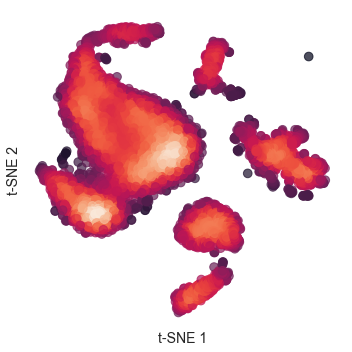

CPU times: user 52.9 s, sys: 1.69 s, total: 54.6 s
Wall time: 54.5 s


In [5]:
%%time
retina_1_tSNE = fcc_tSNE(retina_1_PCA.results, perplexity=30)
retina_1_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1267e54e0>)

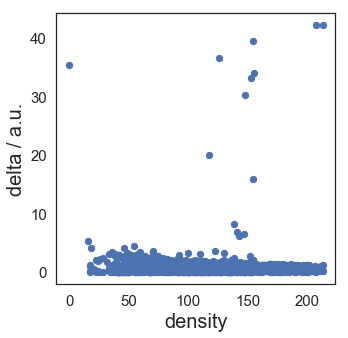

In [6]:
retina_1_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120e4efd0>)

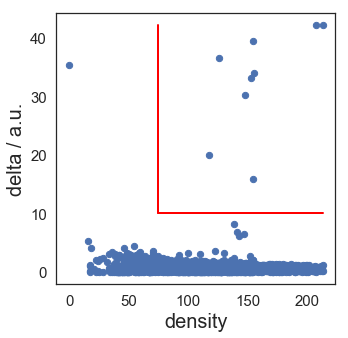

In [9]:
retina_1_tSNE.clu.assign(75, 10)
retina_1_tSNE.clu.draw_decision_graph(min_delta=retina_1_tSNE.clu.min_delta, min_density=retina_1_tSNE.clu.min_density)

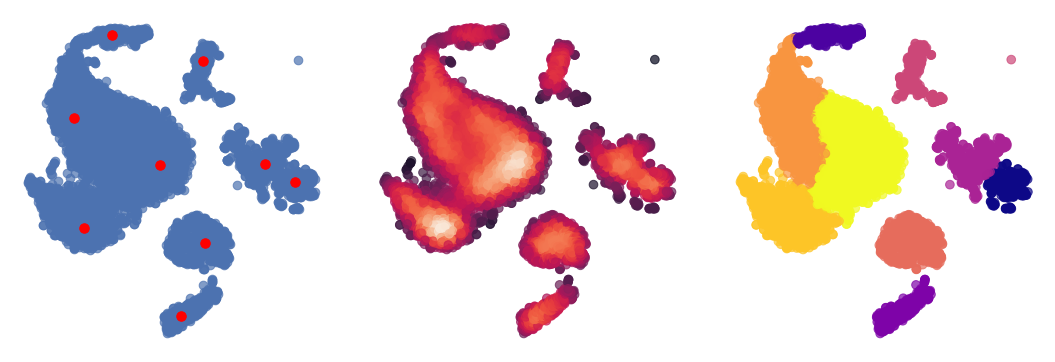

In [10]:
# visualize clustering
retina_1_tSNE.plot_clusters()

In [11]:
retina_1_tSNE.silhouette_score

0.46477214

---
#### 2. downsample dataset proportionally using predefined clusters from t-SNE above

In [16]:
# downsample to total of ~1000 cells, maintaining cluster proportions so it (theoretically) clusters the same way when processed
retina_1_reduced = RNA_counts.downsample_proportional(counts_obj=retina_1, clu_membership=retina_1_tSNE.clu.membership, n_cells=1000, seed=18)

In [17]:
# should be slightly more than 1000 cells because it rounds up to nearest cell number for each cluster proportion
retina_1_reduced.data.shape 

(1004, 20478)

Make sure the porportional downsampling worked by doing the same clustering as before

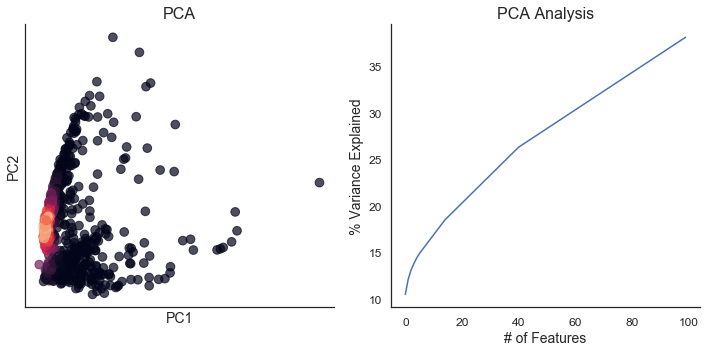

CPU times: user 5.47 s, sys: 589 ms, total: 6.06 s
Wall time: 3.66 s


In [18]:
%%time
retina_1_reduced_PCA = fcc_PCA(retina_1_reduced.arcsinh_norm(), n_components=100)
retina_1_reduced_PCA.plot()

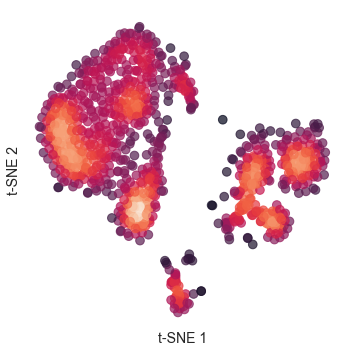

CPU times: user 6.1 s, sys: 239 ms, total: 6.34 s
Wall time: 6.21 s


In [19]:
%%time
retina_1_reduced_tSNE = fcc_tSNE(retina_1_reduced_PCA.results, perplexity=30)
retina_1_reduced_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120e8cb70>)

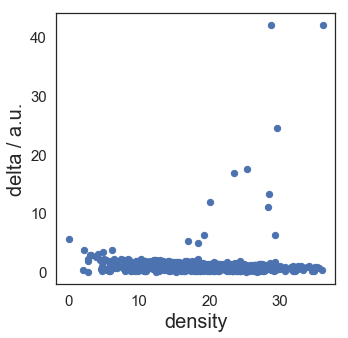

In [20]:
retina_1_reduced_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1211ebe80>)

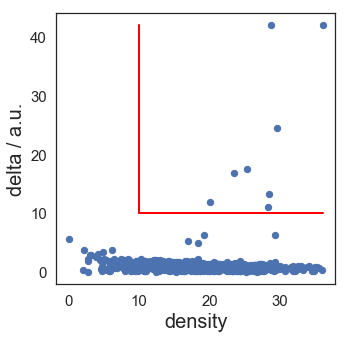

In [21]:
retina_1_reduced_tSNE.clu.assign(10, 10)
retina_1_reduced_tSNE.clu.draw_decision_graph(min_delta=retina_1_reduced_tSNE.clu.min_delta, min_density=retina_1_reduced_tSNE.clu.min_density)

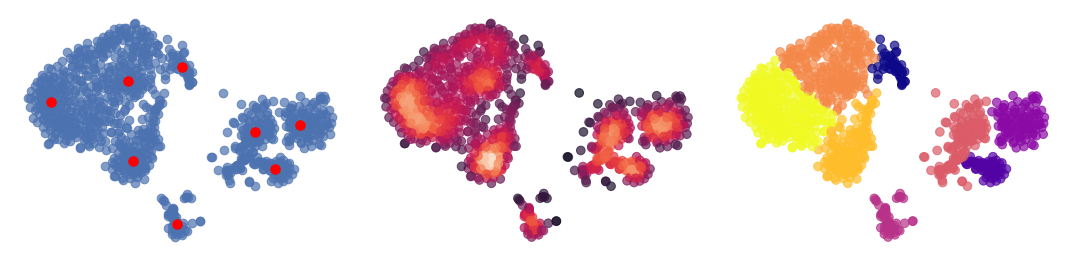

In [22]:
retina_1_reduced_tSNE.plot_clusters()

In [23]:
retina_1_reduced_tSNE.silhouette_score

0.4477261

Similar number of clusters and silhouette score for 100-component PCA-primed t-SNE.  Seems like the proportional downsampling works.

---
#### 3. perform NVR feature selection on downsampled data

In [24]:
%time retina_1_reduced_nvr = RNA_counts.nvr_select(retina_1_reduced)

Start min_conn_k
3 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 428.4928262233734 seconds
done

Selected 923 variable genes

CPU times: user 7min 3s, sys: 2.73 s, total: 7min 6s
Wall time: 7min 9s


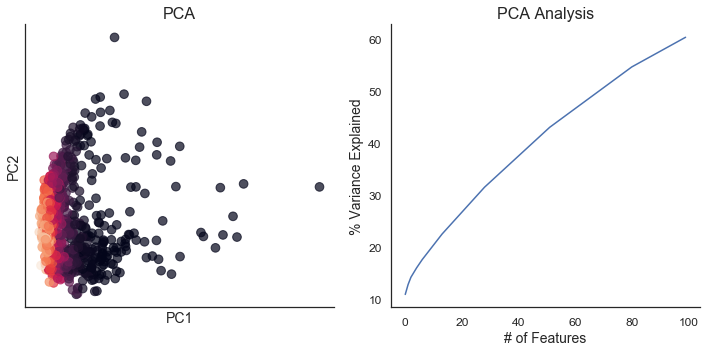

CPU times: user 1.02 s, sys: 156 ms, total: 1.17 s
Wall time: 665 ms


In [25]:
%%time
retina_1_reduced_nvr_PCA = fcc_PCA(retina_1_reduced_nvr.arcsinh_norm(), n_components=100)
retina_1_reduced_nvr_PCA.plot()

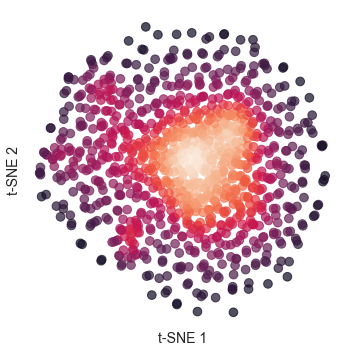

CPU times: user 7.09 s, sys: 72.8 ms, total: 7.17 s
Wall time: 7.03 s


In [26]:
%%time
retina_1_reduced_nvr_tSNE = fcc_tSNE(retina_1_reduced_nvr_PCA.results, perplexity=30)
retina_1_reduced_nvr_tSNE.plot()

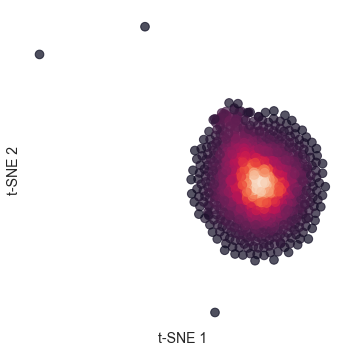

CPU times: user 8.86 s, sys: 111 ms, total: 8.97 s
Wall time: 8.93 s


In [27]:
%%time
retina_1_reduced_nvr_tSNE = fcc_tSNE(retina_1_reduced_nvr.arcsinh_norm(), perplexity=30)
retina_1_reduced_nvr_tSNE.plot()

NVR seems to make the resulting data 'lumpy'...  even when you prime with PCA.
Need to try another feature selection method

---
#### 3. perform ~~NVR~~ "brute force" feature selection on downsampled data

In [28]:
# let's select the top 500 most variable genes
%time retina_1_reduced_select = RNA_counts.var_select(retina_1_reduced, 500)

CPU times: user 314 ms, sys: 222 ms, total: 536 ms
Wall time: 657 ms


In [29]:
retina_1_reduced_select.data.shape # now we have 1000 cells and 500 most variable "features" (genes)

(1004, 500)

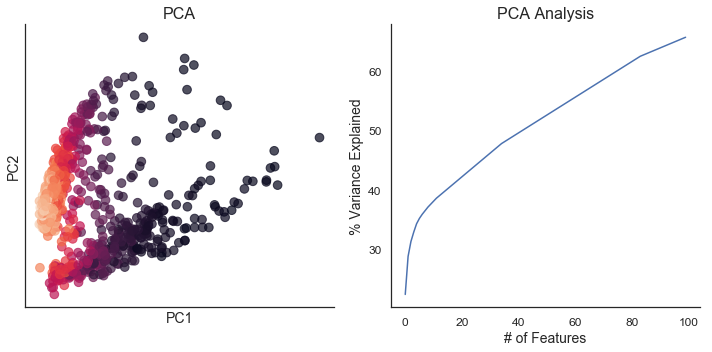

CPU times: user 1 s, sys: 114 ms, total: 1.12 s
Wall time: 637 ms


In [30]:
%%time
retina_1_reduced_select_PCA = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=100)
retina_1_reduced_select_PCA.plot()

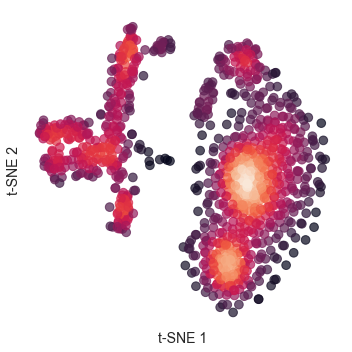

CPU times: user 6.13 s, sys: 251 ms, total: 6.38 s
Wall time: 6.4 s


In [31]:
%%time
retina_1_reduced_select_tSNE = fcc_tSNE(retina_1_reduced_select_PCA.results, perplexity=30)
retina_1_reduced_select_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c3c2d30>)

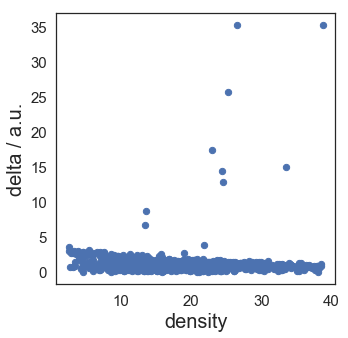

In [32]:
retina_1_reduced_select_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12bf5c668>)

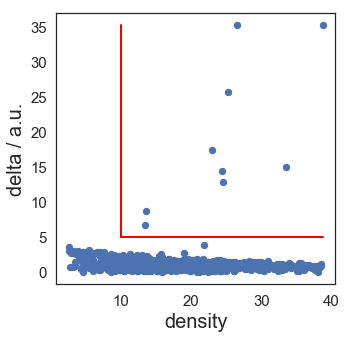

In [33]:
retina_1_reduced_select_tSNE.clu.assign(10,5)
retina_1_reduced_select_tSNE.clu.draw_decision_graph(min_delta=retina_1_reduced_select_tSNE.clu.min_delta, min_density=retina_1_reduced_select_tSNE.clu.min_density)

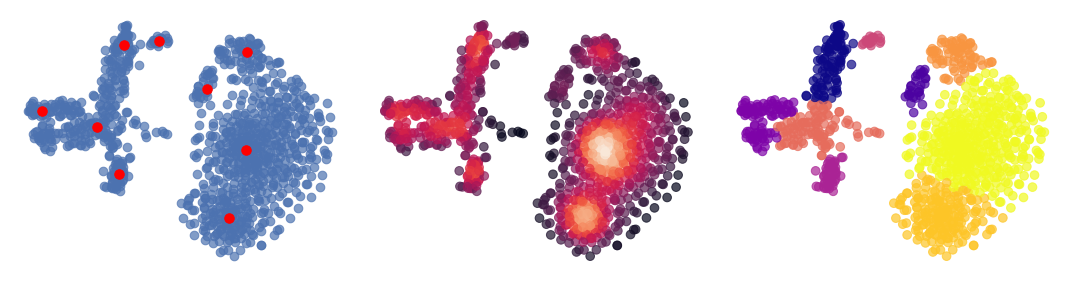

In [34]:
retina_1_reduced_select_tSNE.plot_clusters()

In [35]:
retina_1_reduced_select_tSNE.silhouette_score

0.3795203

So this seems to work better. The 100-component PCA-primed t-SNE looks pretty much like it did before selecting variable genes.  The silhouette score for the 9 clusters is a little lower, suggesting we may have lost a bit of resolution by throwing out ~19500 genes.  
Let's proceed.

---
#### 4. perform DR techniques on downsampled, feature-selected dataset and compare to original

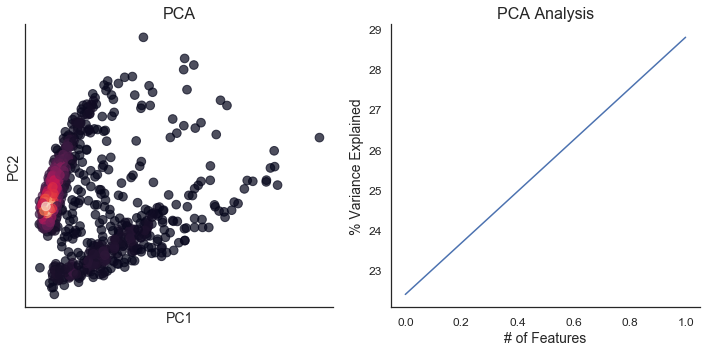

CPU times: user 733 ms, sys: 62.4 ms, total: 795 ms
Wall time: 437 ms


In [48]:
%%time
# Let's PCA with 2 components, then increase to compare results
retina_1_reduced_select_PCA_2 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=2)
retina_1_reduced_select_PCA_2.plot()

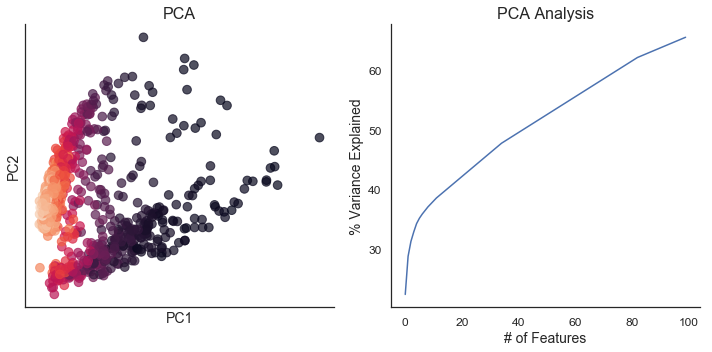

CPU times: user 910 ms, sys: 87.1 ms, total: 997 ms
Wall time: 537 ms


In [38]:
%%time
# now let's do the typical 100-component PCA
retina_1_reduced_select_PCA_100 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=100)
retina_1_reduced_select_PCA_100.plot()

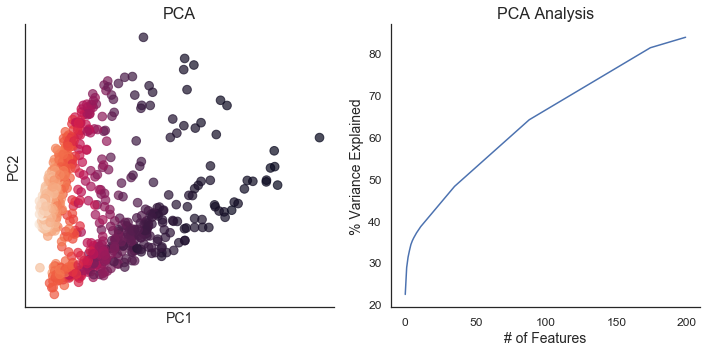

CPU times: user 1.05 s, sys: 99.6 ms, total: 1.15 s
Wall time: 645 ms


In [39]:
%%time
# let's crank it up to 200 components to see if we can cover 100% of the dataset variability
retina_1_reduced_select_PCA_200 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=200)
retina_1_reduced_select_PCA_200.plot()

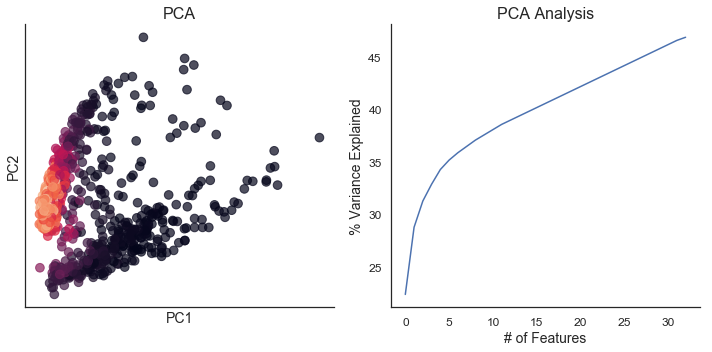

CPU times: user 791 ms, sys: 72.3 ms, total: 863 ms
Wall time: 476 ms


In [43]:
%%time
# let's also test 33 components for a head-to-head comparison with DCA
retina_1_reduced_select_PCA_33 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=33)
retina_1_reduced_select_PCA_33.plot()

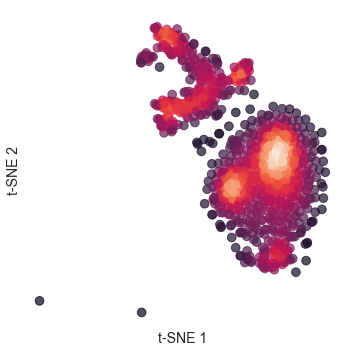

CPU times: user 7.03 s, sys: 259 ms, total: 7.28 s
Wall time: 7.19 s


In [40]:
%%time
# now, perform t-SNE on feature-selected dataset
retina_1_reduced_select_tSNE = fcc_tSNE(retina_1_reduced_select.arcsinh_norm(), perplexity=30)
retina_1_reduced_select_tSNE.plot()

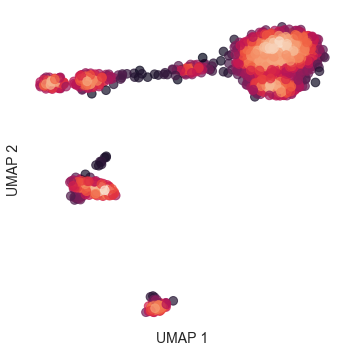

CPU times: user 7.67 s, sys: 324 ms, total: 7.99 s
Wall time: 8.15 s


In [41]:
%%time
# and UMAP on feature-selected dataset
retina_1_reduced_select_UMAP = fcc_UMAP(retina_1_reduced_select.arcsinh_norm(), perplexity=30)
retina_1_reduced_select_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1264e7320>)

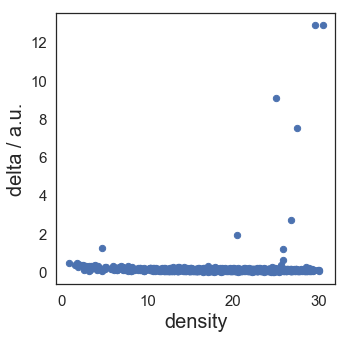

In [44]:
retina_1_reduced_select_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126e16b38>)

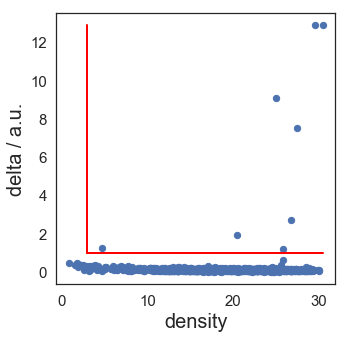

In [45]:
retina_1_reduced_select_UMAP.clu.assign(3, 1)
retina_1_reduced_select_UMAP.clu.draw_decision_graph(min_delta=retina_1_reduced_select_UMAP.clu.min_delta, min_density=retina_1_reduced_select_UMAP.clu.min_density)

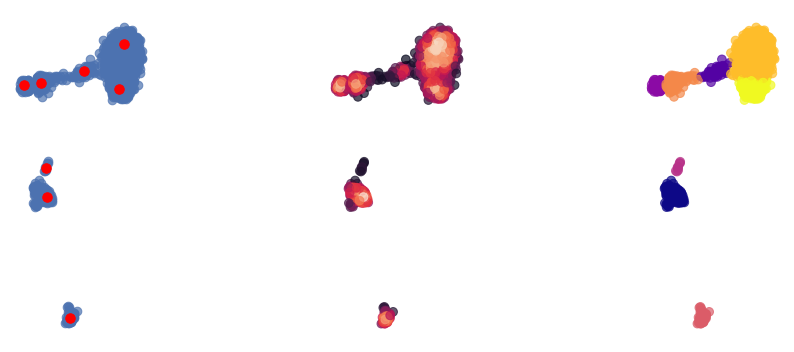

In [46]:
retina_1_reduced_select_UMAP.plot_clusters()

In [47]:
retina_1_reduced_select_UMAP.silhouette_score

0.51264805

In [42]:
# now try DCA to reduce to 33 components as well
%time retina_1_reduced_select_DCA = fcc_DCA(retina_1_reduced_select.counts)

DCA: Successfully preprocessed 500 genes and 1004 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 18.2 s, sys: 891 ms, total: 19.1 s
Wall time: 11.1 s


##### Now compare the Euclidean distances in all the techniques

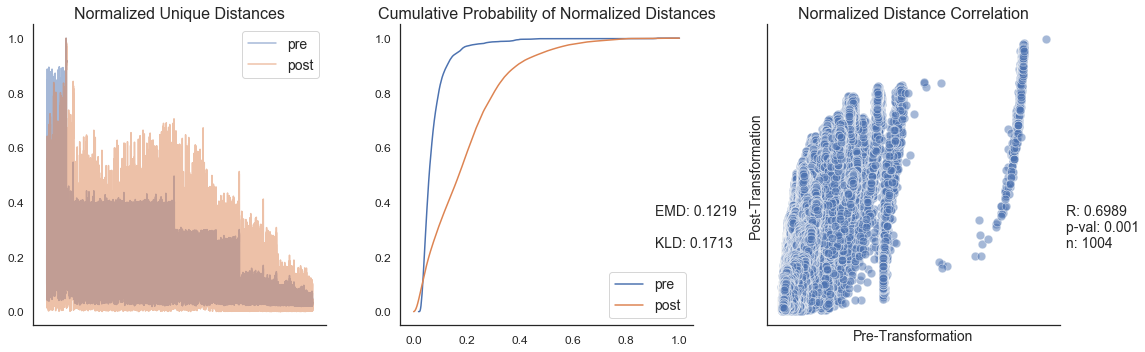

CPU times: user 23.6 s, sys: 3.66 s, total: 27.3 s
Wall time: 26.9 s


((0.6988687843909317, 0.001, 1004), 0.12193210174669775, 0.17126548574795294)

In [49]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_2.distance_matrix())

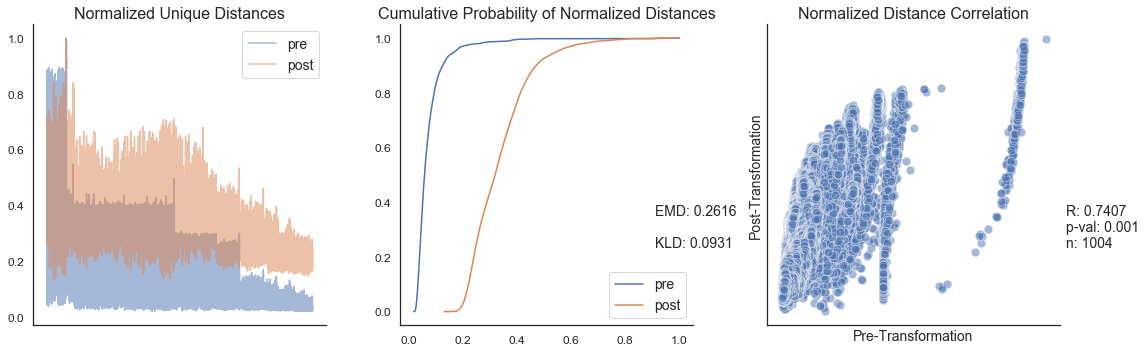

CPU times: user 23.5 s, sys: 4.32 s, total: 27.9 s
Wall time: 27.2 s


((0.7407349985344114, 0.001, 1004), 0.2616259011329059, 0.09314878414606045)

In [50]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_100.distance_matrix())

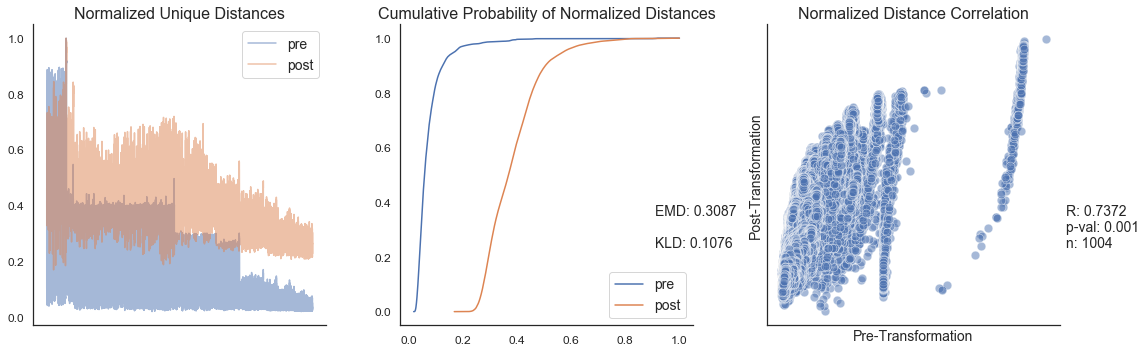

CPU times: user 24.3 s, sys: 4.72 s, total: 29 s
Wall time: 28.8 s


((0.7371991689423737, 0.001, 1004), 0.3086518221876116, 0.10764307706127231)

In [51]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_200.distance_matrix())

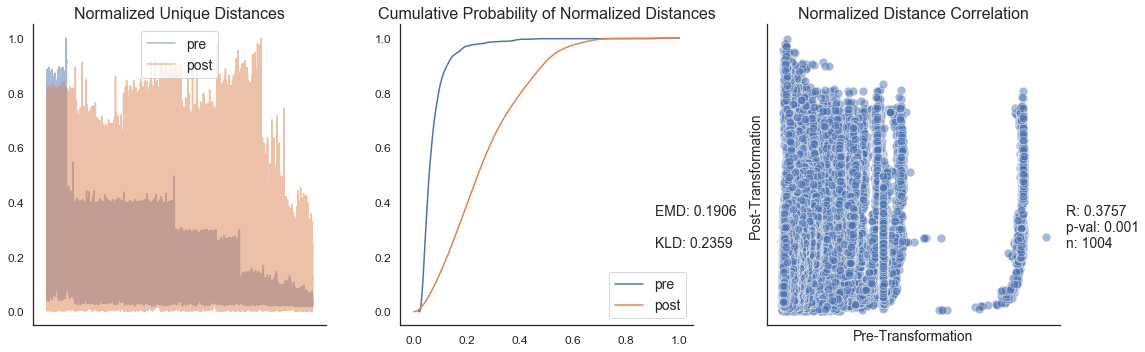

CPU times: user 25.8 s, sys: 4.39 s, total: 30.2 s
Wall time: 29.7 s


((0.37571521183742335, 0.001, 1004), 0.19062337046113695, 0.2358882506851843)

In [52]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_tSNE.distance_matrix())

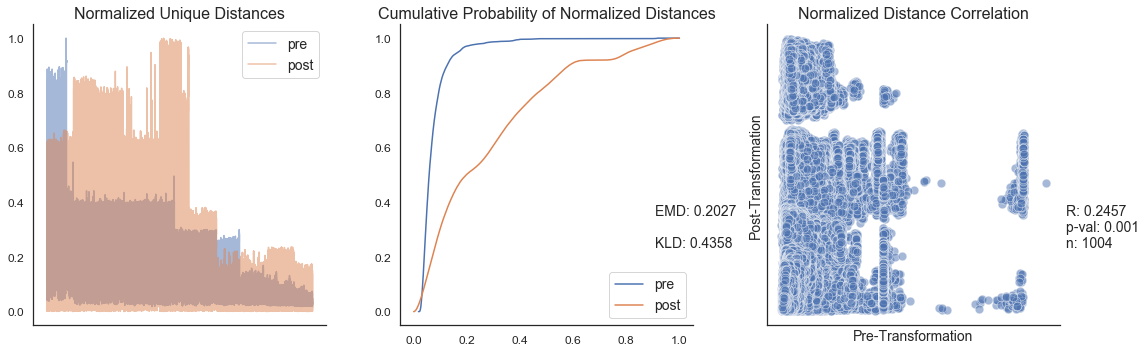

CPU times: user 23.9 s, sys: 4.07 s, total: 27.9 s
Wall time: 27.6 s


((0.24565746622931575, 0.001, 1004), 0.20273826417308585, 0.43584614268102534)

In [53]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_UMAP.distance_matrix())

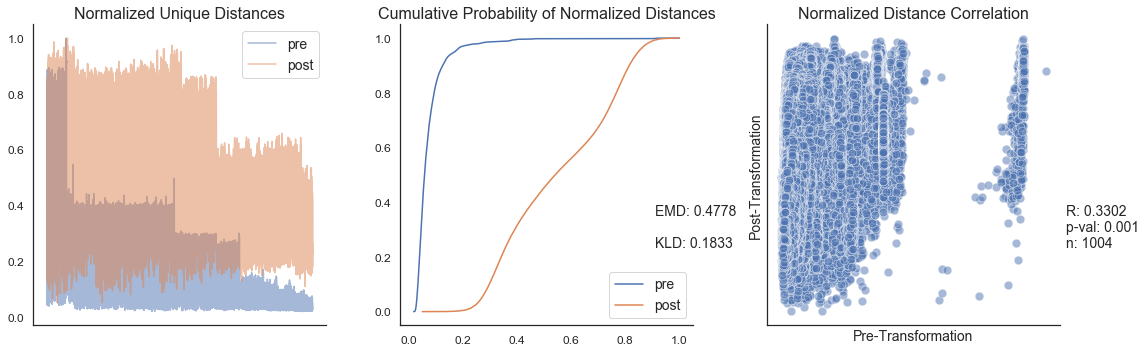

CPU times: user 24.3 s, sys: 4.57 s, total: 28.9 s
Wall time: 28.4 s


((0.33017874562155486, 0.001, 1004), 0.477840873699083, 0.1833289244890141)

In [54]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_DCA.distance_matrix())

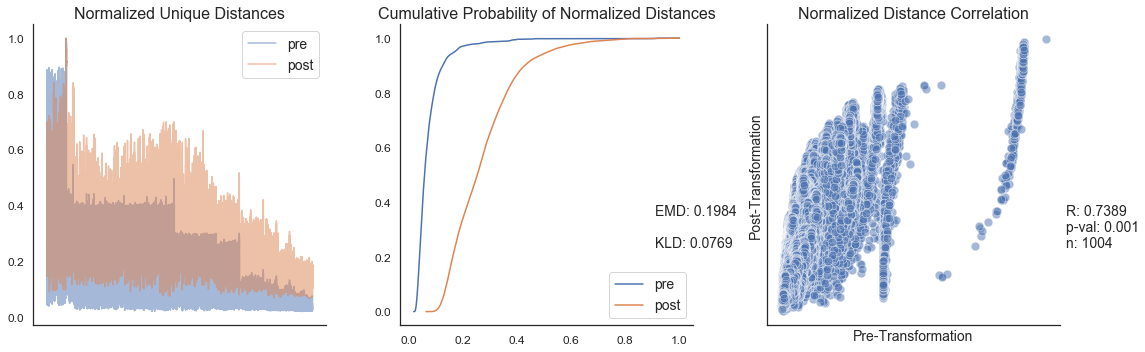

CPU times: user 22.9 s, sys: 2.97 s, total: 25.9 s
Wall time: 25.5 s


((0.7388711691932808, 0.001, 1004), 0.19839059946130488, 0.07689574838422467)

In [55]:
# now PCA with 33 components to compare DCA to
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_33.distance_matrix())

---
#### 5. Repeat for continuous dataset

In [56]:
AS1 = read_hdf5('inputs/Adj-Norm-1291-AS1.h5')

In [57]:
AS1['counts_0'].shape

(17590, 38254)

In [58]:
AS1 = RNA_counts(AS1['counts_0'], labels=[None,None])

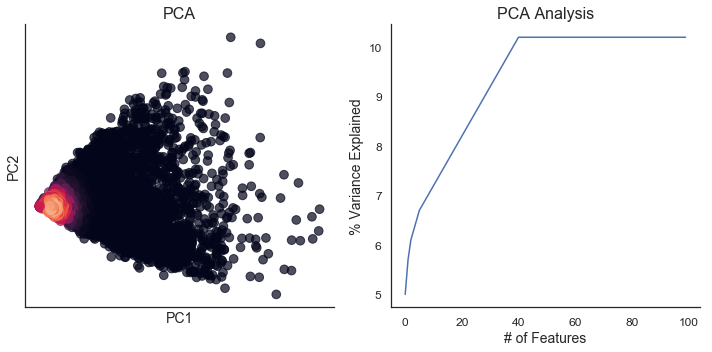

CPU times: user 5min 32s, sys: 4min 10s, total: 9min 43s
Wall time: 13min 19s


In [59]:
%%time
AS1_PCA = fcc_PCA(AS1.arcsinh_norm(), n_components=100)
AS1_PCA.plot()

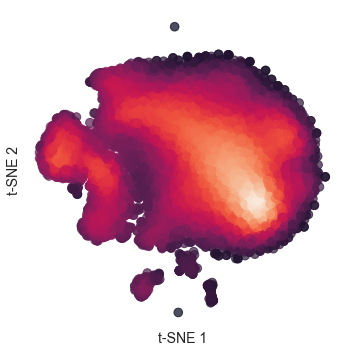

CPU times: user 3min 49s, sys: 11.8 s, total: 4min 1s
Wall time: 4min 18s


In [60]:
%%time
AS1_tSNE = fcc_tSNE(AS1_PCA.results, perplexity=30)
AS1_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12696cd30>)

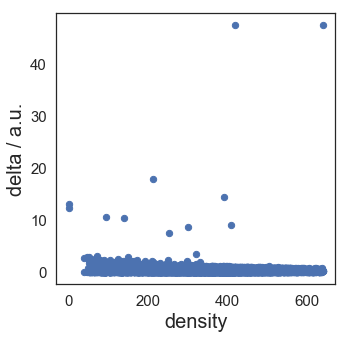

In [61]:
AS1_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1270fe208>)

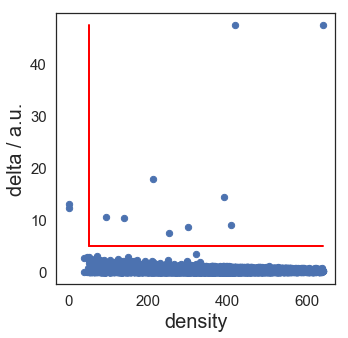

In [62]:
AS1_tSNE.clu.assign(50, 5)
AS1_tSNE.clu.draw_decision_graph(min_delta=AS1_tSNE.clu.min_delta, min_density=AS1_tSNE.clu.min_density)

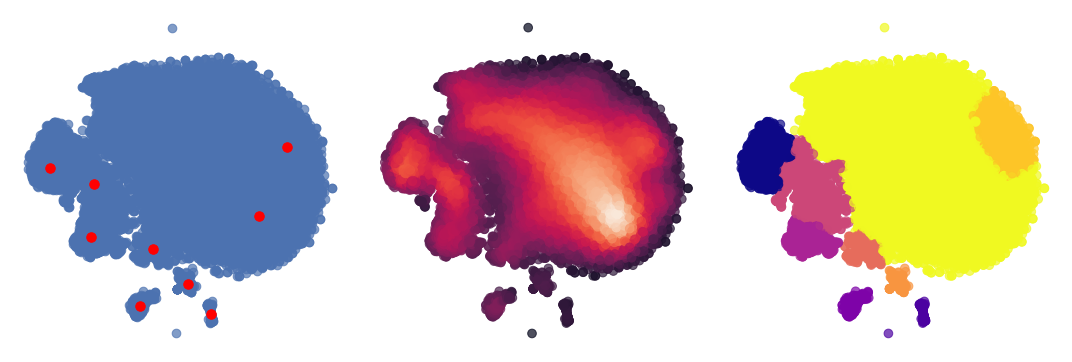

In [63]:
AS1_tSNE.plot_clusters()

In [64]:
AS1_tSNE.silhouette_score

0.040938504

In [65]:
AS1_0 = RNA_counts.downsample_proportional(counts_obj=AS1, clu_membership=AS1_tSNE.clu.membership, n_cells=1000, seed=18)

In [66]:
AS1_0_select = RNA_counts.var_select(counts_obj=AS1_0, n_features=500)

In [68]:
AS1_0_select.data.shape # now we should have 500 genes and ~1000 cells

(1005, 500)

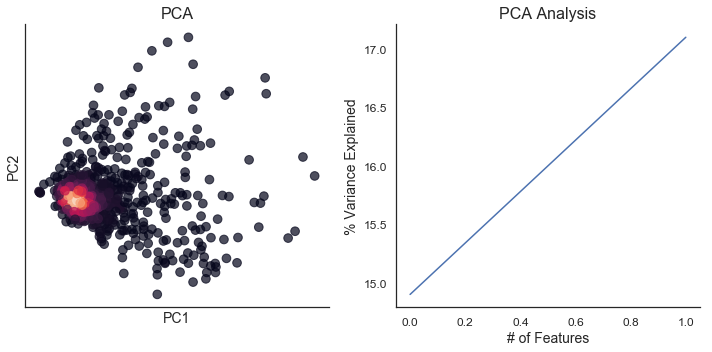

CPU times: user 839 ms, sys: 128 ms, total: 967 ms
Wall time: 582 ms


In [69]:
%%time
AS1_0_select_PCA_2 = fcc_PCA(AS1_0_select.arcsinh_norm(), n_components=2)
AS1_0_select_PCA_2.plot()

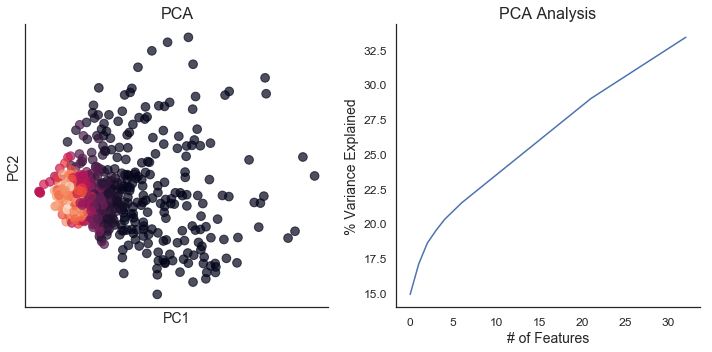

CPU times: user 860 ms, sys: 98.1 ms, total: 958 ms
Wall time: 535 ms


In [70]:
%%time
# 33-component PCA to compare to DCA
AS1_0_select_PCA_33 = fcc_PCA(AS1_0_select.arcsinh_norm(), n_components=33)
AS1_0_select_PCA_33.plot()

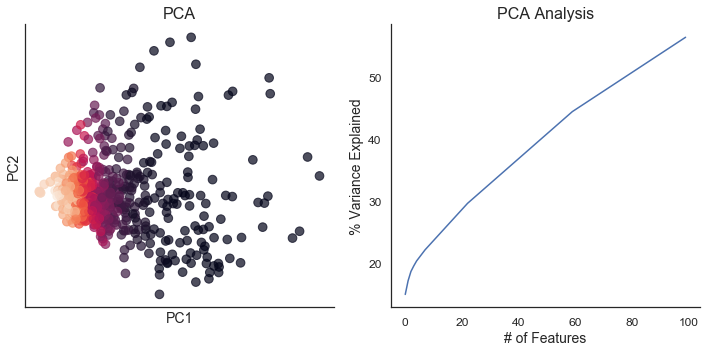

CPU times: user 934 ms, sys: 94.2 ms, total: 1.03 s
Wall time: 625 ms


In [82]:
%%time
# 100-component PCA to compare to DCA
AS1_0_select_PCA_100 = fcc_PCA(AS1_0_select.arcsinh_norm(), n_components=100)
AS1_0_select_PCA_100.plot()

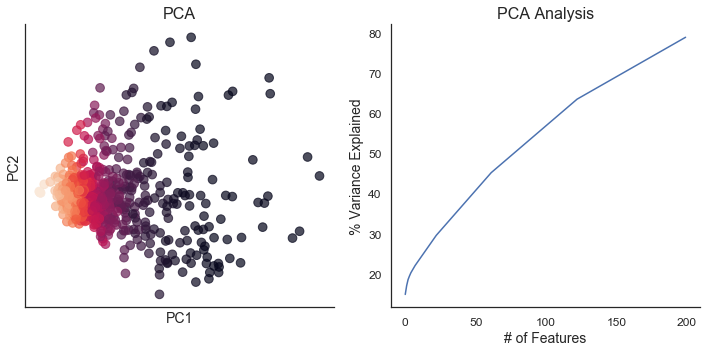

CPU times: user 1.08 s, sys: 103 ms, total: 1.18 s
Wall time: 672 ms


In [83]:
%%time
# 200-component PCA to compare to DCA
AS1_0_select_PCA_200 = fcc_PCA(AS1_0_select.arcsinh_norm(), n_components=200)
AS1_0_select_PCA_200.plot()

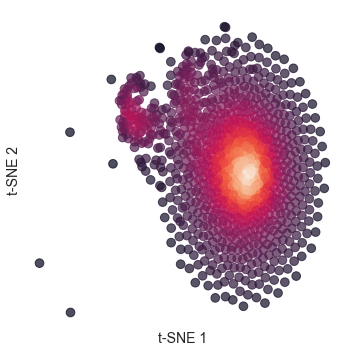

CPU times: user 7.99 s, sys: 151 ms, total: 8.14 s
Wall time: 8.04 s


In [71]:
%%time
AS1_0_select_tSNE = fcc_tSNE(AS1_0_select.arcsinh_norm(), perplexity=30)
AS1_0_select_tSNE.plot()

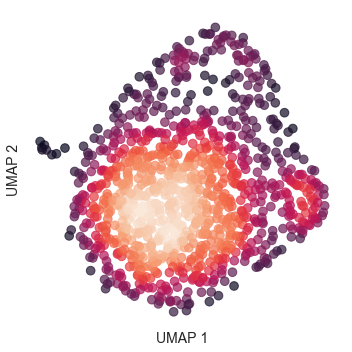

CPU times: user 2.81 s, sys: 220 ms, total: 3.03 s
Wall time: 2.97 s


In [72]:
%%time
AS1_0_select_UMAP = fcc_UMAP(AS1_0_select.arcsinh_norm(), perplexity=30)
AS1_0_select_UMAP.plot()

In [73]:
%%time
# perform DCA to reduce to 33 features
AS1_0_select_DCA = fcc_DCA(AS1_0_select.counts)

DCA: Successfully preprocessed 500 genes and 1005 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 19.8 s, sys: 1.85 s, total: 21.7 s
Wall time: 14.6 s


Perform Euclidean distance comparisons

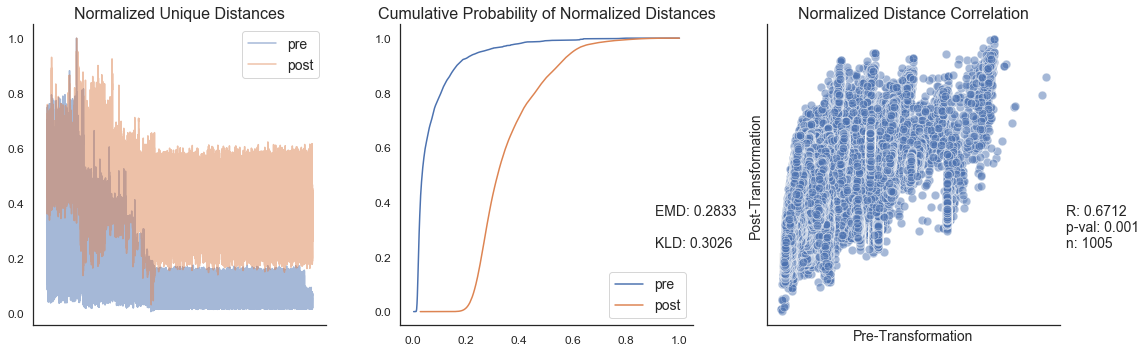

CPU times: user 24 s, sys: 3.22 s, total: 27.3 s
Wall time: 27.2 s


In [84]:
# 100-component PCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_PCA_100.distance_matrix())

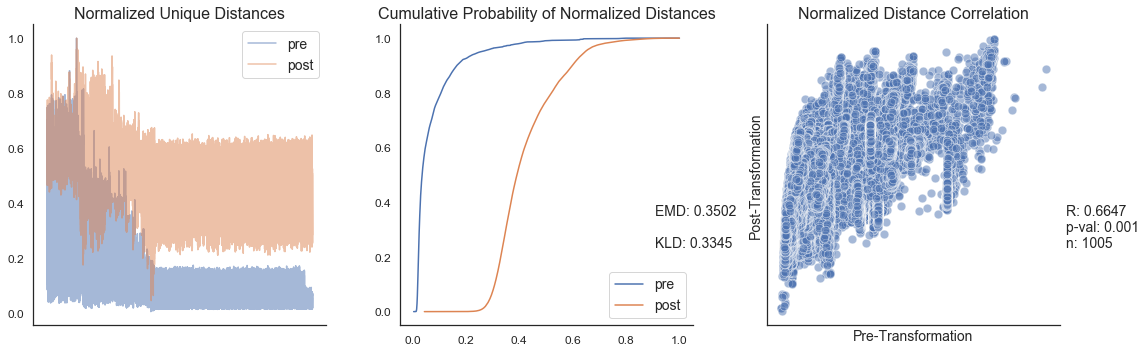

CPU times: user 23.4 s, sys: 3.26 s, total: 26.7 s
Wall time: 26.1 s


In [85]:
# 200-component PCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_PCA_200.distance_matrix())

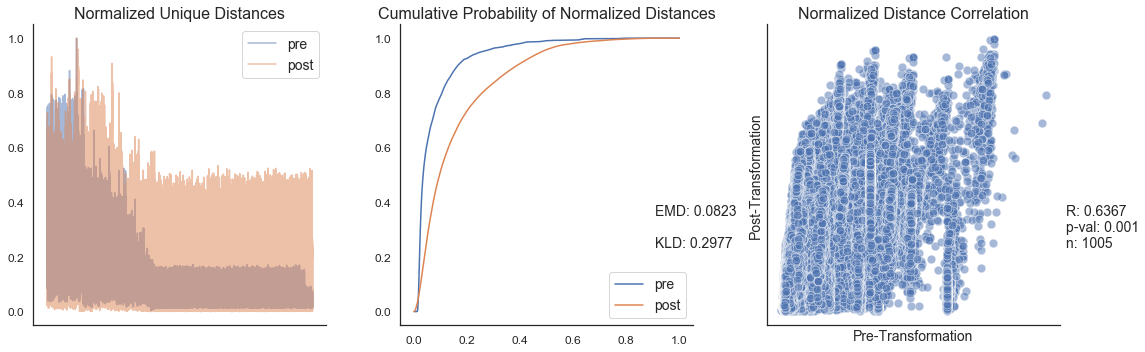

CPU times: user 23.5 s, sys: 3.24 s, total: 26.7 s
Wall time: 26.3 s


In [74]:
# 2-component PCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_PCA_2.distance_matrix())

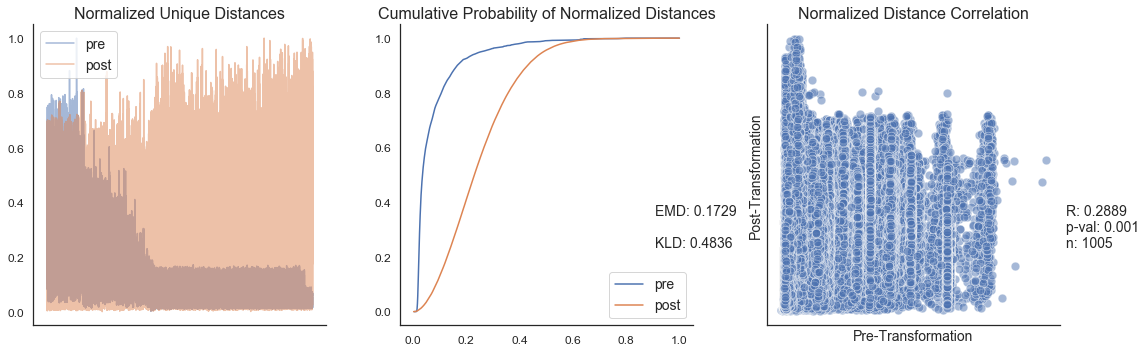

CPU times: user 25.4 s, sys: 3.11 s, total: 28.5 s
Wall time: 28.1 s


In [75]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_tSNE.distance_matrix())

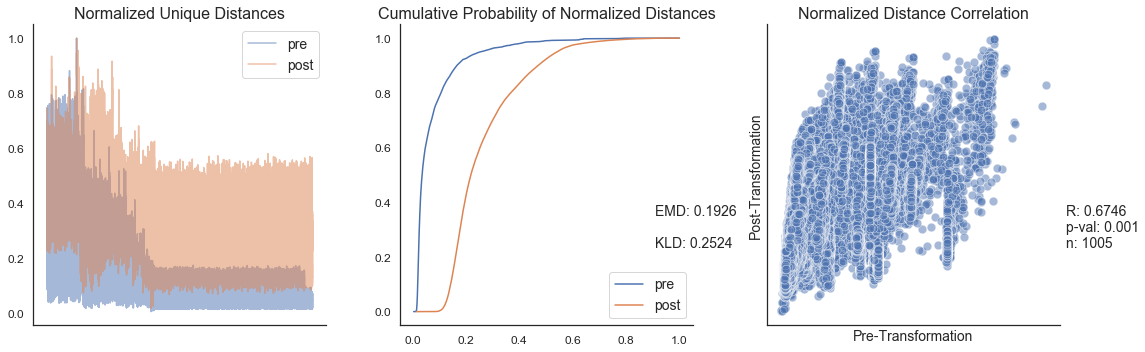

CPU times: user 23.3 s, sys: 3.05 s, total: 26.3 s
Wall time: 25.8 s


In [76]:
# 33-component PCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_PCA_33.distance_matrix())

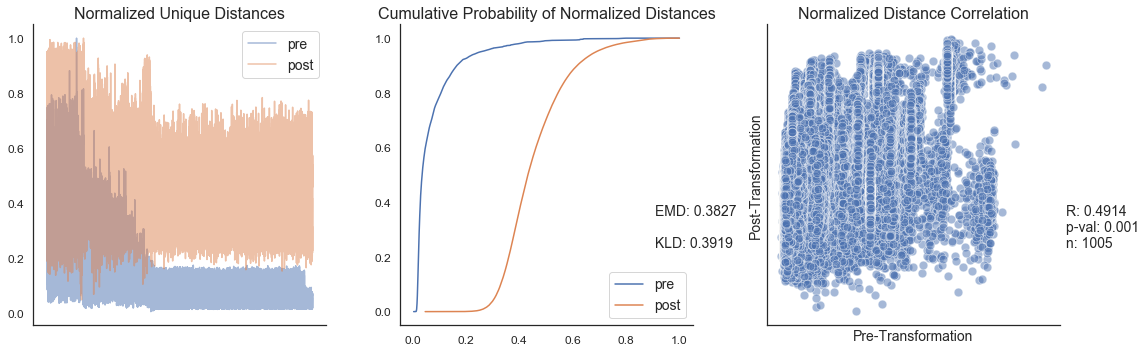

CPU times: user 23.9 s, sys: 4.16 s, total: 28 s
Wall time: 27.5 s


In [77]:
# DCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_DCA.distance_matrix())

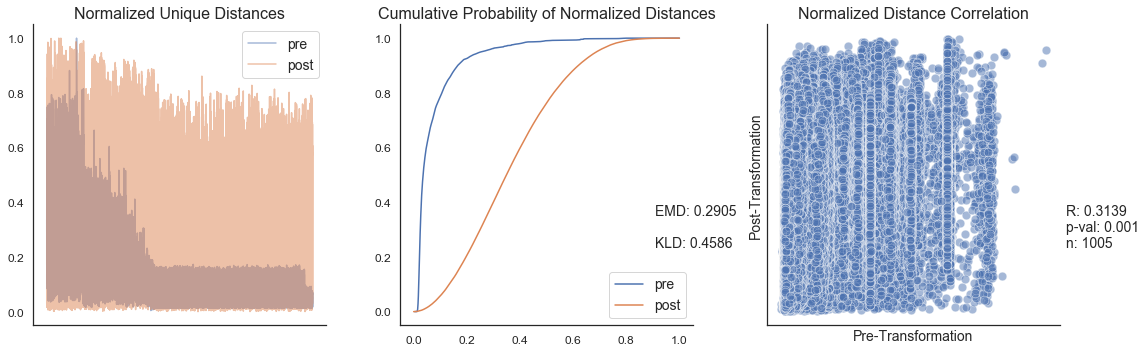

CPU times: user 23.7 s, sys: 3.97 s, total: 27.7 s
Wall time: 27.3 s


In [78]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_UMAP.distance_matrix())

---
#### 6. NVR selection on continuous dataset

In [79]:
%time AS1_0_NVR = RNA_counts.nvr_select(counts_obj=AS1_0, scale=1000)

Start min_conn_k
2 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 351.16938996315 seconds
done

Selected 164 variable genes



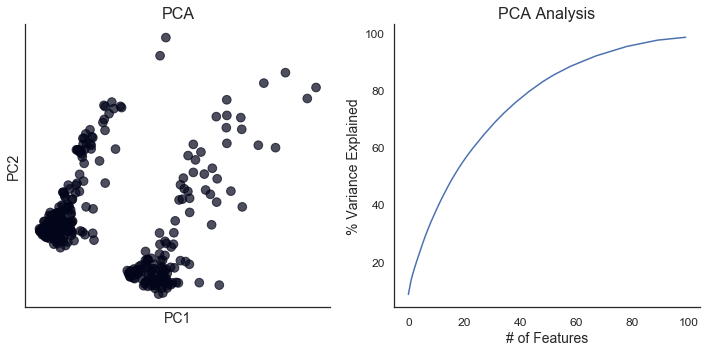

CPU times: user 772 ms, sys: 77.4 ms, total: 850 ms
Wall time: 460 ms


In [89]:
%%time
AS1_0_NVR_PCA_100 = fcc_PCA(AS1_0_NVR.arcsinh_norm(), n_components=100)
AS1_0_NVR_PCA_100.plot()

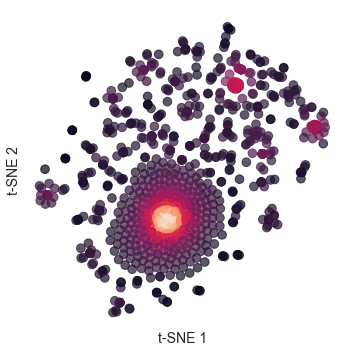

CPU times: user 6.8 s, sys: 334 ms, total: 7.13 s
Wall time: 7.03 s


In [90]:
%%time
AS1_0_NVR_PCAtSNE = fcc_tSNE(AS1_0_NVR_PCA_100.results, perplexity=30)
AS1_0_NVR_PCAtSNE.plot()

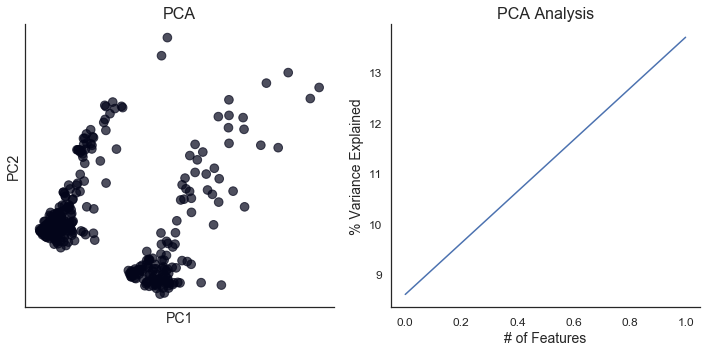

CPU times: user 646 ms, sys: 53.2 ms, total: 699 ms
Wall time: 391 ms


In [91]:
%%time
AS1_0_NVR_PCA_2 = fcc_PCA(AS1_0_NVR.arcsinh_norm(), n_components=2)
AS1_0_NVR_PCA_2.plot()

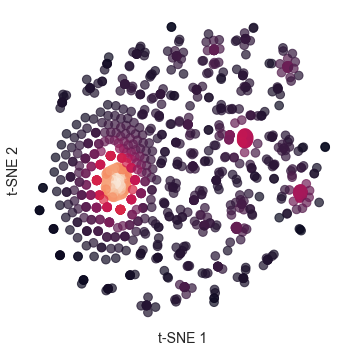

CPU times: user 6.88 s, sys: 373 ms, total: 7.25 s
Wall time: 7.18 s


In [87]:
%%time
AS1_0_NVR_tSNE = fcc_tSNE(AS1_0_NVR.arcsinh_norm(), perplexity=30)
AS1_0_NVR_tSNE.plot()

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/umap/umap_.py:926: RuntimeWarning: invalid value encountered in less
  graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0


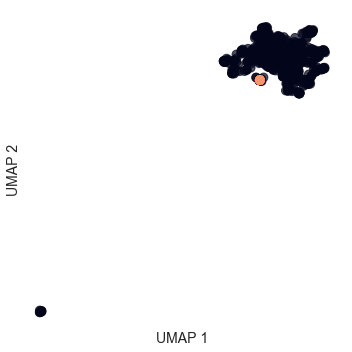

CPU times: user 2.91 s, sys: 144 ms, total: 3.06 s
Wall time: 2.86 s


In [88]:
%%time
AS1_0_NVR_UMAP = fcc_UMAP(AS1_0_NVR.arcsinh_norm(), perplexity=30)
AS1_0_NVR_UMAP.plot()

Now perform Euclidean distance comparisons

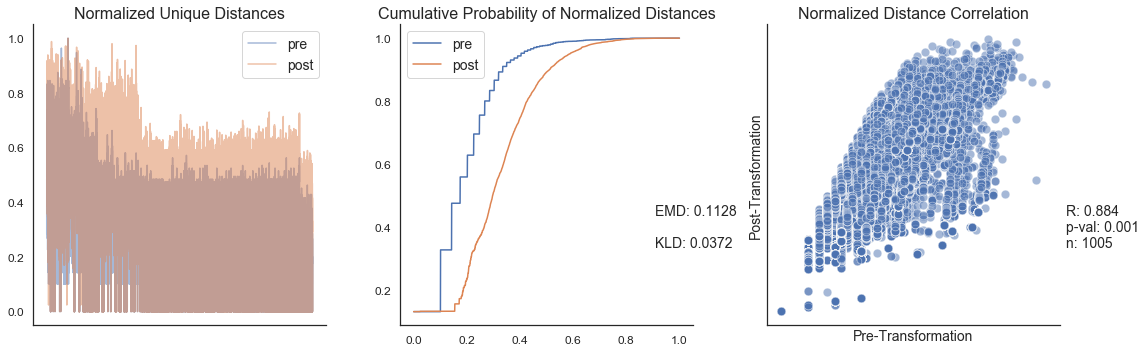

CPU times: user 22.8 s, sys: 3.07 s, total: 25.8 s
Wall time: 25.5 s


In [92]:
# 100-component PCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_PCA_100.distance_matrix())

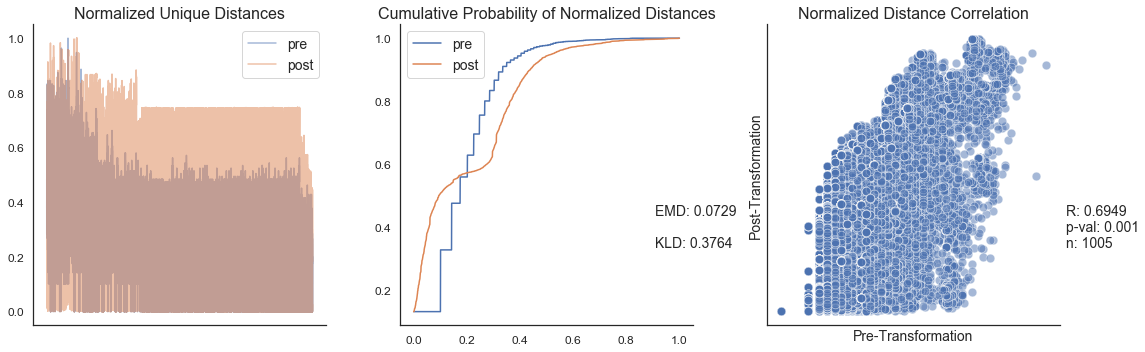

CPU times: user 21.9 s, sys: 2.18 s, total: 24 s
Wall time: 23.5 s


In [93]:
# 2-component PCA
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_PCA_2.distance_matrix())

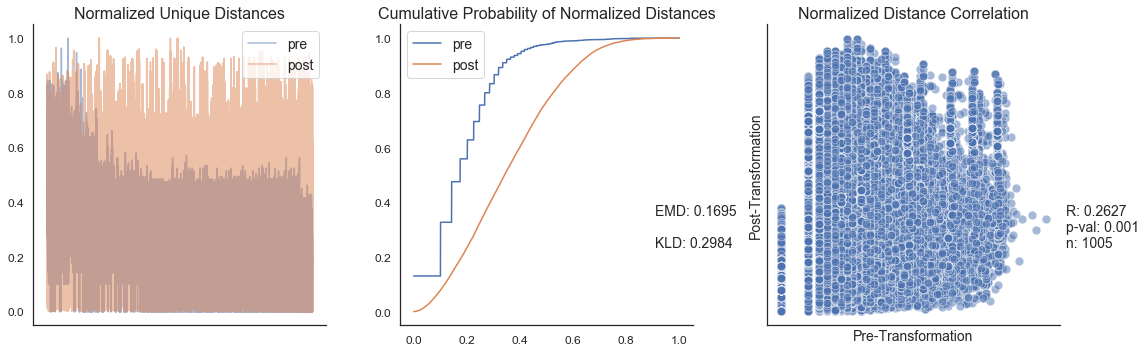

CPU times: user 24.5 s, sys: 2.48 s, total: 26.9 s
Wall time: 26.5 s


In [94]:
# t-SNE on downsampled, feature-selected data
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_tSNE.distance_matrix())

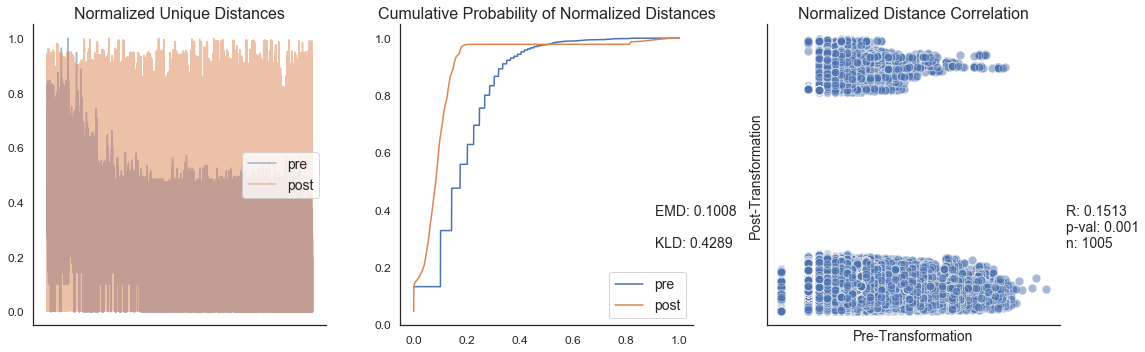

CPU times: user 24.5 s, sys: 2.5 s, total: 27 s
Wall time: 26.9 s


In [95]:
# UMAP on downsampled, feature-selected data
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_UMAP.distance_matrix())